<a href="https://colab.research.google.com/github/kevkn2/projects-mine/blob/main/Project_SNA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
#imports
%pip install demoji
import demoji
import tweepy
import csv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
import sys
import re

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
api_key = "97cfLqHVysRxo6yGHY4axFuHD"
api_key_secret = "eHDP3Diwlsw1rjgNtB8ygyBsFwn3QiE0vmhcxmrWbcgEPK2kGZ"
access_token = "2766312086-F1KzDM80xmQX2gWGWwOX7ePFbcOQkDhSdtKuuGt"
access_token_secret = "mGC9Q21LIQas4pkY4vYCxZ5OH7TXYJjT7zwZondlse1jL"
keyword = "Baim Wong"


OAUTH_KEYS = {'api_key':api_key, 'api_key_secret':api_key_secret, 'access_token_key':access_token,
'access_token_secret':access_token_secret}
auth = tweepy.OAuthHandler(OAUTH_KEYS['api_key'], OAUTH_KEYS['api_key_secret'])

In [4]:
api = tweepy.API(auth, wait_on_rate_limit=True)
if (not api):
  print ("Can't Authenticate")
  sys.exit(-1)
else:
  print ("Scraping data now")
  cursor = tweepy.Cursor(api.search, q=(keyword), result_type="new",count=10000)
  results=[]
  for item in cursor.items(10000): # Remove the limit to 1000
    results.append(item)
  
  print("Scraping Done")

Scraping data now
Scraping Done


In [5]:
def word_only(text):
  result = demoji.replace(text)
  result = re.sub(r"[^a-zA-Z0-9]+"," ",result)
  result = re.sub(r'(!|.)1+', '', result)
  return " ".join(result.split()) 

In [6]:
def to_dataframe(tweets):
  dataset = pd.DataFrame()

  dataset["tweet_created"] = [tweet.created_at for tweet in tweets]
  dataset["username"] = [word_only(tweet.user.name.lower()) for tweet in tweets]
  dataset["user_follower_count"] = [tweet.user.followers_count for tweet in tweets]
  dataset["tweet_text"] = [word_only(tweet.text.encode("utf-8")
                        .lower().decode("utf-8")) for tweet in tweets]
  dataset["tweet_retweet_count"] = [tweet.retweet_count for tweet in tweets]

  dataset["source"] = [tweet for tweet in range(len(tweets))]

  for index, tweet in enumerate(dataset["tweet_text"]):
    if re.compile(r"^rt\s").search(tweet):
      try:
        dataset["source"] = dataset["source"].replace([index],
                                                    re.findall(r"(?<=\brt\s)(\w+)", 
                                                               tweet))
      except ValueError:
        print(tweet)
      
    else:
      dataset.loc[index, "source"] = "not_retweet"

  return dataset

In [7]:
dataset = to_dataframe(results)

In [8]:
dataset

,tweet_created,username,user_follower_count,tweet_text,tweet_retweet_count,source
0,2022-10-06 12:33:07,liputan6,4425899,3 fakta terkini kasus prank video kdrt baim wo...,0,not_retweet
1,2022-10-06 12:31:24,kaa,395,kalo mau bandingin tuh minimal nonton dulu kak...,0,not_retweet
2,2022-10-06 12:31:10,ima siti patimah,6,rt wahiidin waduh ngeri kasus terpendam atau p...,71,wahiidin
3,2022-10-06 12:30:42,noor,30190,lagi mece dari baim wong kita belajar,0,not_retweet
4,2022-10-06 12:30:08,it s indah,1,rt ainunrozi temen2 baim wong saat ini temen l...,91,ainunrozi
...,...,...,...,...,...,...
9995,2022-10-03 23:44:24,fhri,55,rt teukuryz baim wong wongnya itu wong edan,734,teukuryz
9996,2022-10-03 23:44:19,ultimate coordinator,129,grandypp i have no idea who baim wong is anyway,0,not_retweet
9997,2022-10-03 23:44:14,ikesaurus,675,rt ainunrozi golongan orang2 keren yang tidak ...,4295,ainunrozi
9998,2022-10-03 23:43:47,,239,rt jooctavius niko junius sama subscribe baim ...,424,jooctavius


In [9]:
dataset["source"].value_counts()

babecabiita      3697
not_retweet      1890
ainunrozi         733
grandypp          513
detikcom          310
                 ... 
detikhot            1
wahiidin            1
cloudscloche        1
spoktoberwish       1
andkrma             1
Name: source, Length: 211, dtype: int64

In [10]:
#terlalu banyak sumber lain, jadi digabungkan saja
mask = dataset.source.map(dataset.source.value_counts()) <= 200
dataset.source = dataset.source.mask(mask, "other")

dataset["source"].value_counts()

babecabiita     3697
other           2416
not_retweet     1890
ainunrozi        733
grandypp         513
detikcom         310
ardianpancaa     222
winnerwave       219
Name: source, dtype: int64

In [11]:
#cek username, apa ada yg salah
dataset["username"].value_counts()

                        869
juna haduw               33
citayam fashion week     30
yolan                    27
pikiran rakyat           25
                       ... 
vandereich                1
annisa fadhilah           1
racunshopee               1
nuguseyo                  1
ikesaurus                 1
Name: username, Length: 7229, dtype: int64

In [12]:
#banyak empty value, segera diubah
dataset["username"][dataset["username"] == ""] = "only_emot"
dataset["username"].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


only_emot               869
juna haduw               33
citayam fashion week     30
yolan                    27
pikiran rakyat           25
                       ... 
vandereich                1
annisa fadhilah           1
racunshopee               1
nuguseyo                  1
ikesaurus                 1
Name: username, Length: 7229, dtype: int64

In [13]:
dataset.to_csv(keyword+".csv", index=False)
dataset

,tweet_created,username,user_follower_count,tweet_text,tweet_retweet_count,source
0,2022-10-06 12:33:07,liputan6,4425899,3 fakta terkini kasus prank video kdrt baim wo...,0,not_retweet
1,2022-10-06 12:31:24,kaa,395,kalo mau bandingin tuh minimal nonton dulu kak...,0,not_retweet
2,2022-10-06 12:31:10,ima siti patimah,6,rt wahiidin waduh ngeri kasus terpendam atau p...,71,other
3,2022-10-06 12:30:42,noor,30190,lagi mece dari baim wong kita belajar,0,not_retweet
4,2022-10-06 12:30:08,it s indah,1,rt ainunrozi temen2 baim wong saat ini temen l...,91,ainunrozi
...,...,...,...,...,...,...
9995,2022-10-03 23:44:24,fhri,55,rt teukuryz baim wong wongnya itu wong edan,734,other
9996,2022-10-03 23:44:19,ultimate coordinator,129,grandypp i have no idea who baim wong is anyway,0,not_retweet
9997,2022-10-03 23:44:14,ikesaurus,675,rt ainunrozi golongan orang2 keren yang tidak ...,4295,ainunrozi
9998,2022-10-03 23:43:47,only_emot,239,rt jooctavius niko junius sama subscribe baim ...,424,other


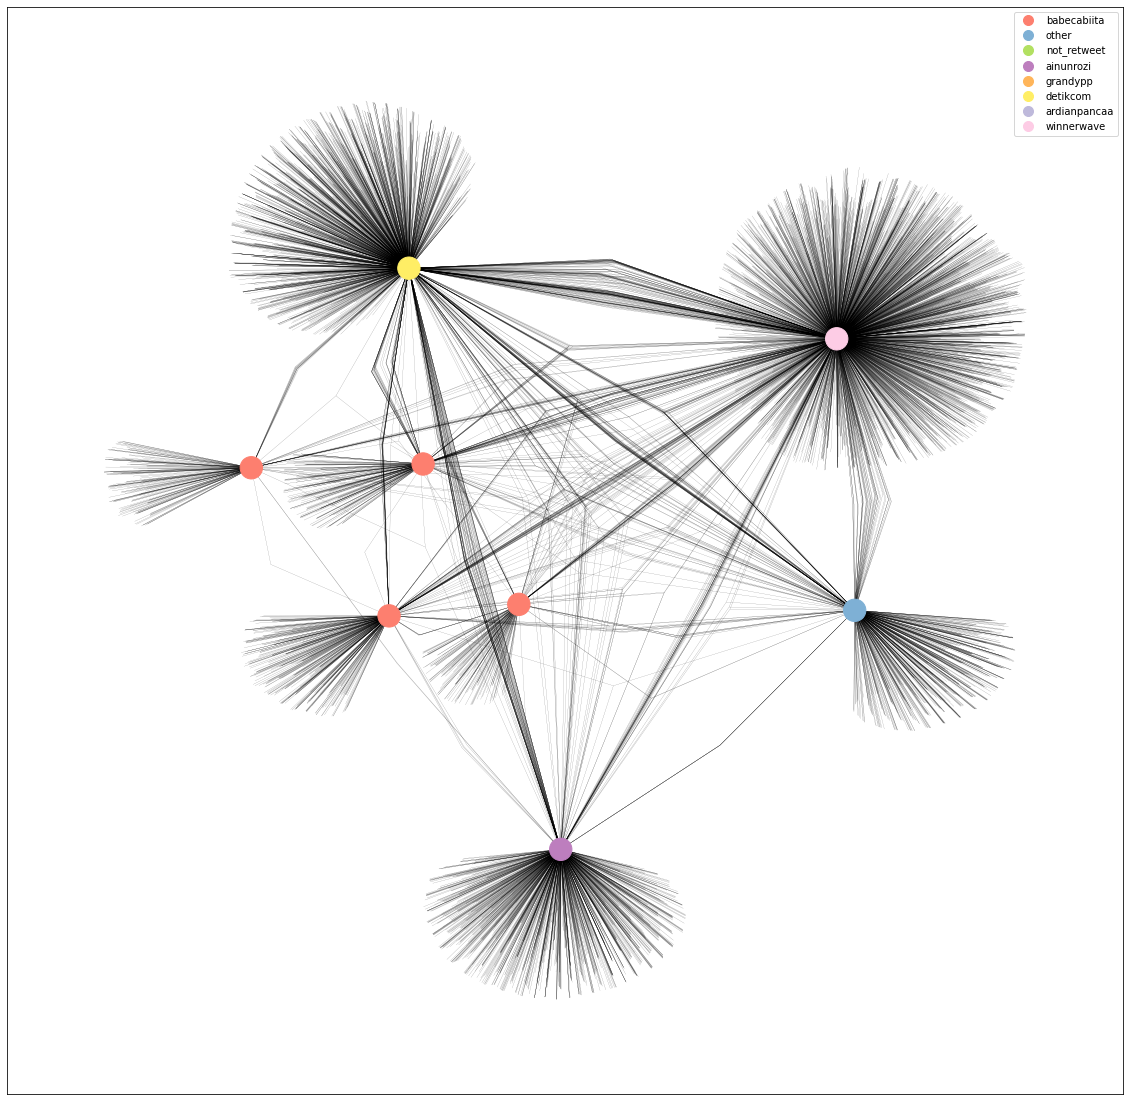

In [24]:
#lets make the map
source_dict = dataset["source"].value_counts().to_dict()

map_dataset = pd.DataFrame({
    "from":[row for row in dataset["source"]],
    "to":[row for row in dataset["username"]]
})

G = nx.from_pandas_edgelist(map_dataset, 
                            "from", "to", 
                            create_using = nx.Graph())

carac = pd.DataFrame({
    "ID": [row for row in source_dict.keys()],
    "value": [row for row in source_dict.values()]
})

carac= carac.set_index('ID')
carac=carac.reindex(G.nodes())

color_map = ["#fd7f6f", 
            "#7eb0d5", 
            "#b2e061", 
            "#bd7ebe", 
            "#ffb55a", 
            "#ffee65", 
            "#beb9db", 
            "#fdcce5"]

cmap = matplotlib.colors.ListedColormap(color_map)

plt.figure(figsize=(20,20))

nx.draw_networkx(G, 
                 with_labels=False, 
                 node_color=carac['value'], 
                 cmap=cmap, 
                 node_size=500, 
                 width = 0.1)

legend_elements = [Line2D([0], [0], 
                          marker='o', 
                          color=color_map[index], 
                          label=list(source_dict.keys())[index], 
                          lw=0,
                          markerfacecolor=color_map[index], 
                          markersize=10) for index in range(len(color_map))]

ax = plt.gca()
ax.legend(handles=legend_elements, loc='upper right')


plt.show()